In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.special import boxcox1p

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import (LinearRegression, Lasso, Ridge, ElasticNet,
                                  LassoCV, RidgeCV, ElasticNetCV)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV

from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
folder = '/kaggle/input/house-prices-advanced-regression-techniques/'
train = pd.read_csv(folder+'train.csv')
test = pd.read_csv(folder+'test.csv')
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [4]:
train_ids = train['Id'].tolist()
test_ids = test['Id'].tolist()
data = pd.concat([train, test])
data = data.set_index('Id')
data.shape

(2919, 80)

# First Impression of Important Variables

## Dependent Variable

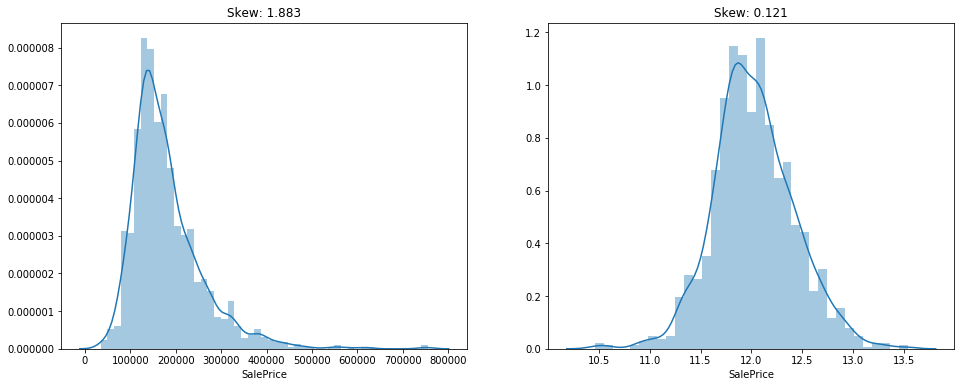

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
sns.distplot(data['SalePrice'], ax=ax[0]).set_title('Skew: {}'.format(round(data['SalePrice'].skew(),3)))
sns.distplot(np.log(data['SalePrice']), ax=ax[1]).set_title('Skew: {}'.format(round(np.log(data['SalePrice']).skew(),3)));

In [6]:
data['SalePrice_log'] = np.log(data['SalePrice'])
data = data.drop(columns=['SalePrice'])

We can see why the competition asks us to predict log(SalePrice): SalePrice follows a log-normal distribution, so we convert it to log scale.

## Variables Highly Correlated with SalePrice_log

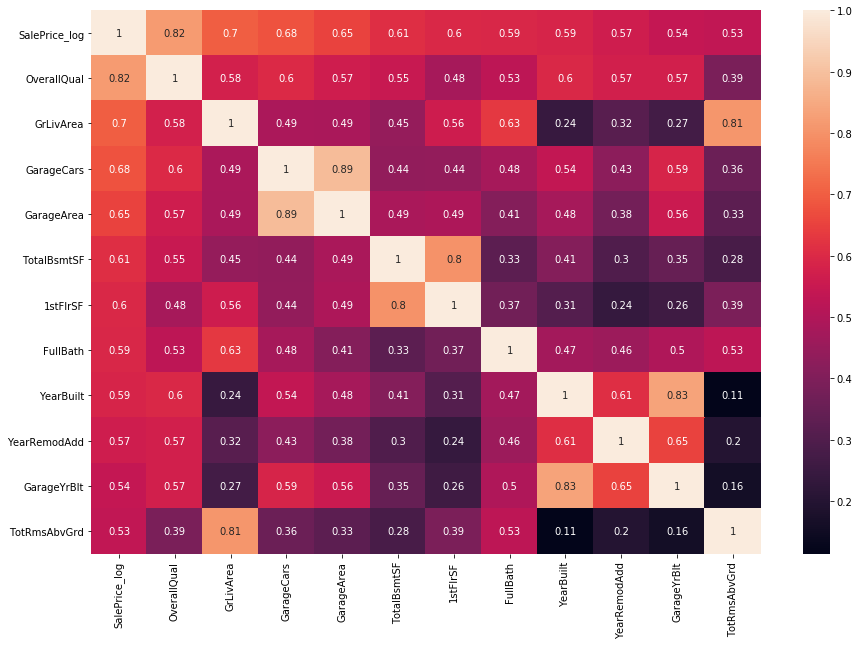

In [7]:
corr_price = abs(data.corr()['SalePrice_log']).sort_values(ascending=False)
high_corr_price = corr_price[corr_price > 0.5].index
plt.figure(figsize=(15,10))
sns.heatmap(data[high_corr_price].corr(), annot=True)

### OverallQual

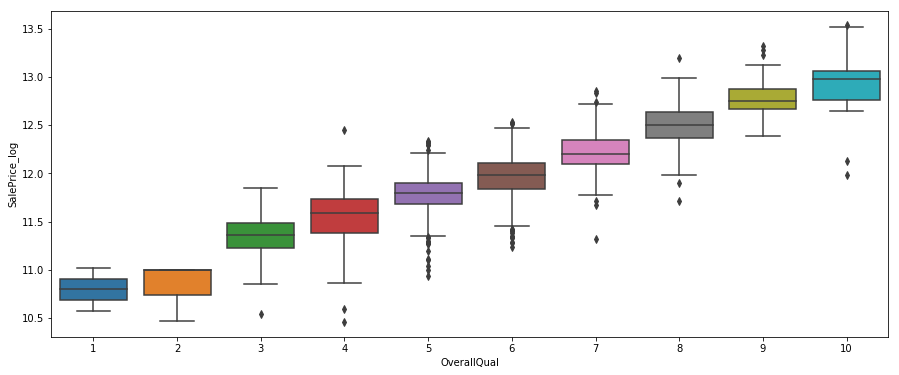

In [8]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='OverallQual', y='SalePrice_log', data=data)

We see that this is an apporximately linear relationship (medians are in increasing order). There are no severe outliers.

## GrLivArea

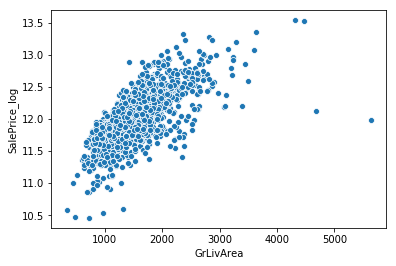

In [9]:
sns.scatterplot(x='GrLivArea', y='SalePrice_log', data=data)

Again we see a linear relationship. Note that there are two possible outliers: those with SalePrice_log less than 12.5 and GrLivArea greater than 4000.

# Variable Groups With Missing Values
Let's have a look at the variables with missing data. Many variables fall neatly into groups, so when possible we'll look at each group as a whole. We'll also compile a list of each type of variable (categorical, ordinal, numerical), and we'll convert categorical variables to ordinal when necessary.

In [10]:
cat_vars = []
ord_vars = []
num_vars = []
qualities_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

def get_map_to_ordinal(ordered_categories):
    return dict(zip(ordered_categories, range(len(ordered_categories))))

In [11]:
data.loc[:,data.isna().any()].isna().sum()

Alley            2721
BsmtCond           82
BsmtExposure       82
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFinType1       79
BsmtFinType2       80
BsmtFullBath        2
BsmtHalfBath        2
BsmtQual           81
BsmtUnfSF           1
Electrical          1
Exterior1st         1
Exterior2nd         1
Fence            2348
FireplaceQu      1420
Functional          2
GarageArea          1
GarageCars          1
GarageCond        159
GarageFinish      159
GarageQual        159
GarageType        157
GarageYrBlt       159
KitchenQual         1
LotFrontage       486
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2814
PoolQC           2909
SaleType            1
TotalBsmtSF         1
Utilities           2
SalePrice_log    1459
dtype: int64

## Basement Variables
Description from Kaggle. All 11 basement variables have missing numbers. The number of missing values is in brackets:  
BsmtQual: Height of the basement (81)  
BsmtCond: General condition of the basement (82)  
BsmtExposure: Walkout or garden level basement walls (82)  
BsmtFinType1: Quality of basement finished area (79)  
BsmtFinSF1: Type 1 finished square feet (1)  
BsmtFinType2: Quality of second finished area (if present) (80)  
BsmtFinSF2: Type 2 finished square feet (1)  
BsmtUnfSF: Unfinished square feet of basement area (1)  
TotalBsmtSF: Total square feet of basement area (1)  
BsmtFullBath: Basement full bathrooms (2)  
BsmtHalfBath: Basement half bathrooms (2)

In [12]:
miss_many_vars = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
miss_5_idx = data.index[data[miss_many_vars].isna().all(axis=1)]
zero_sf_idx = data.index[(data['TotalBsmtSF'] == 0) | (data['TotalBsmtSF'].isna())]
set(miss_5_idx) == set(zero_sf_idx)

True

Therefore all 79 rows are missing all five of the above variables do not have a basement. Let's have a look at the variables one by one, starting with those missing only a few columns.

In [13]:
miss_few_vars = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
data[miss_few_vars].dtypes

BsmtFinSF1      float64
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
BsmtFullBath    float64
BsmtHalfBath    float64
dtype: object

In [14]:
data[miss_few_vars] = data[miss_few_vars].fillna(0)
num_vars.extend(miss_few_vars)

These missing variables are all numerical, and we can reason that a null indicates 0.

In [15]:
for var in miss_many_vars:
    print(var, data[var].unique())

BsmtQual ['Gd' 'TA' 'Ex' nan 'Fa']
BsmtCond ['TA' 'Gd' nan 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' nan]
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']


Let's add a new category that represents 'no basement'.

In [16]:
for var in miss_many_vars:
    data.loc[miss_5_idx, var] = data.loc[miss_5_idx, var].fillna('NA')

Now let's replace the remaining nulls with the modes.

In [17]:
data[miss_many_vars] = data[miss_many_vars].fillna(data.mode().iloc[0])
for var in miss_many_vars:
    print(var, data[var].unique())

BsmtQual ['Gd' 'TA' 'Ex' 'NA' 'Fa']
BsmtCond ['TA' 'Gd' 'NA' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'NA']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'NA' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'NA' 'ALQ' 'Rec' 'LwQ' 'GLQ']


Each of these variables are ordinal, so we'll convert them to ordered integers.

In [18]:
data = data.replace({'BsmtQual': qualities_map, 'BsmtCond': qualities_map})
data['BsmtExposure'] = data['BsmtExposure'].map(get_map_to_ordinal(['NA', 'No', 'Mn', 'Av', 'Gd']))
order = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
data['BsmtFinType1'] = data['BsmtFinType1'].map(get_map_to_ordinal(order))
data['BsmtFinType2'] = data['BsmtFinType2'].map(get_map_to_ordinal(order))
ord_vars.extend(miss_many_vars)

In [19]:
data[miss_many_vars + miss_few_vars].isna().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

In [20]:
data.loc[:,data.isna().any()].isna().sum()

Alley            2721
Electrical          1
Exterior1st         1
Exterior2nd         1
Fence            2348
FireplaceQu      1420
Functional          2
GarageArea          1
GarageCars          1
GarageCond        159
GarageFinish      159
GarageQual        159
GarageType        157
GarageYrBlt       159
KitchenQual         1
LotFrontage       486
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2814
PoolQC           2909
SaleType            1
Utilities           2
SalePrice_log    1459
dtype: int64

## Garage Variables
GarageType: Garage location (157)  
GarageYrBlt: Year garage was built (159)  
GarageFinish: Interior finish of the garage (159)  
GarageCars: Size of garage in car capacity (1)  
GarageArea: Size of garage in square feet (1)  
GarageQual: Garage quality (159)  
GarageCond: Garage condition (159)

In [21]:
data[['GarageCars', 'GarageArea']] = data[['GarageCars', 'GarageArea']].fillna(0)

In [22]:
miss_vars = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
miss_5_idx = data.index[data[miss_vars].isna().all(axis=1)]
print((data.loc[miss_5_idx,'GarageArea'] == 0).sum())

157


So each of the 157 entries that miss all five of these variables have no garage. For 4 of these variables we can replace with 'NA'. We'll replace missing GarageYrBlt with YearBuilt.

In [23]:
for var in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[var] = data[var].fillna('NA')
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['YearBuilt'])

Now convert to ordinal where necessary.

In [24]:
data['GarageFinish'] = data['GarageFinish'].map(get_map_to_ordinal(['NA', 'Unf', 'RFn', 'Fin']))
data['GarageQual'] = data['GarageQual'].map({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
data['GarageCond'] = data['GarageCond'].map({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [25]:
data['GarageFinish'].unique()

array([2, 1, 3, 0])

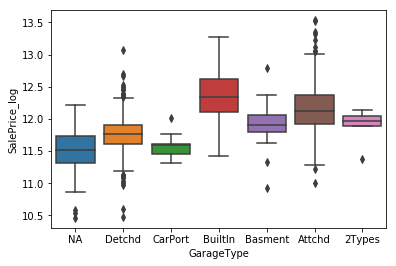

In [26]:
sns.boxplot(x='GarageType', y='SalePrice_log', data=data, 
            order=['NA', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types']);

Doesn't appear to be ordinal, so I'll add it to the list of categorical variables.

In [27]:
cat_vars.append('GarageType')
ord_vars.extend(['GarageFinish', 'GarageQual', 'GarageCond'])
num_vars.extend(['GarageYrBlt', 'GarageArea', 'GarageCars'])

In [28]:
data.loc[:, data.isna().any()].isna().sum()

Alley            2721
Electrical          1
Exterior1st         1
Exterior2nd         1
Fence            2348
FireplaceQu      1420
Functional          2
KitchenQual         1
LotFrontage       486
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2814
PoolQC           2909
SaleType            1
Utilities           2
SalePrice_log    1459
dtype: int64

## Masonry Variables

In [29]:
mason_vars = ['MasVnrArea', 'MasVnrType']
data.loc[data[mason_vars].isna().sum(axis=1) == 1, mason_vars]

,MasVnrArea,MasVnrType
Id,,
2611,198.0,NaN


In [30]:
data.loc[2611, 'MasVnrType'] = data['MasVnrType'].mode().iloc[0]
data[mason_vars] = data[mason_vars].fillna({'MasVnrArea': 0, 'MasVnrType': 'None'})

None       1766
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

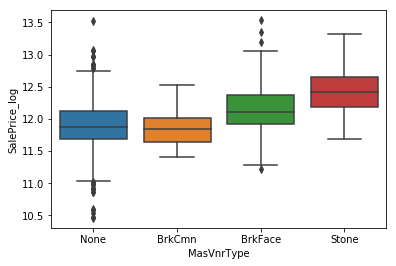

In [31]:
ax = sns.boxplot(x='MasVnrType', y='SalePrice_log', data=data,
                 order=['None', 'BrkCmn', 'BrkFace', 'Stone'])
data['MasVnrType'].value_counts()

Once we merge None and BrkCmn, the variable appears ordinal.

In [32]:
data['MasVnrType'] = data['MasVnrType'].map({'None': 0, 'BrkCmn': 0, 'BrkFace': 1, 'Stone': 2})
ord_vars.append('MasVnrType')
num_vars.append('MasVnrArea')

In [33]:
data.loc[:, data.isna().any() > 0].isna().sum()

Alley            2721
Electrical          1
Exterior1st         1
Exterior2nd         1
Fence            2348
FireplaceQu      1420
Functional          2
KitchenQual         1
LotFrontage       486
MSZoning            4
MiscFeature      2814
PoolQC           2909
SaleType            1
Utilities           2
SalePrice_log    1459
dtype: int64

## Exterior Variables

In [34]:
ext_vars = ['Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond']
data.loc[data[ext_vars].isna().any(axis=1), ext_vars]

,Exterior1st,Exterior2nd,ExterQual,ExterCond
Id,,,,
2152,NaN,NaN,TA,TA


In [35]:
data[ext_vars] = data[ext_vars].fillna(data[ext_vars].mode().iloc[0])

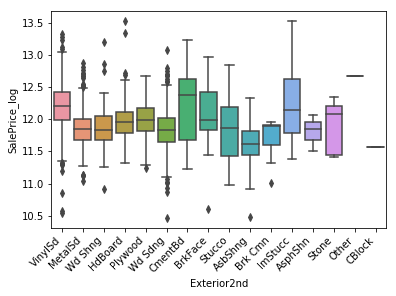

In [36]:
ax = sns.boxplot(x='Exterior2nd', y='SalePrice_log', data=data);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

No clear ordinality. We'll leave these as categories but convert the quality variables to ordinal.

In [37]:
data['ExterQual'] = data['ExterQual'].map(qualities_map)
data['ExterCond'] = data['ExterCond'].map(qualities_map)
cat_vars.extend(['Exterior1st', 'Exterior2nd'])
ord_vars.extend(['ExterQual', 'ExterCond'])

In [38]:
data.loc[:, data.isna().any()].isna().sum()

Alley            2721
Electrical          1
Fence            2348
FireplaceQu      1420
Functional          2
KitchenQual         1
LotFrontage       486
MSZoning            4
MiscFeature      2814
PoolQC           2909
SaleType            1
Utilities           2
SalePrice_log    1459
dtype: int64

## Fireplace Variables

In [39]:
len(data[(data['FireplaceQu'].isna()) & (data['Fireplaces'] == 0)])

1420

In [40]:
data['FireplaceQu'] = data['FireplaceQu'].fillna('NA')
data['FireplaceQu'].unique()

array(['NA', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [41]:
data['FireplaceQu'] = data['FireplaceQu'].map(qualities_map)
data['FireplaceQu'].unique()

array([0, 3, 4, 2, 5, 1])

In [42]:
num_vars.append('Fireplaces')
ord_vars.append('FireplaceQu')

In [43]:
data.loc[:, data.isna().any()].isna().sum()

Alley            2721
Electrical          1
Fence            2348
Functional          2
KitchenQual         1
LotFrontage       486
MSZoning            4
MiscFeature      2814
PoolQC           2909
SaleType            1
Utilities           2
SalePrice_log    1459
dtype: int64

## Electrical

In [44]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode().iloc[0])
data['Electrical'].value_counts()

SBrkr    2672
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

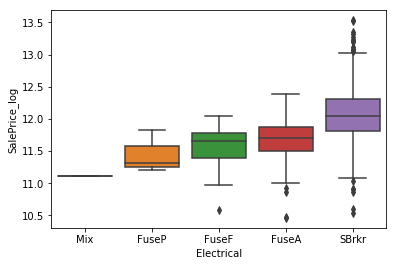

In [45]:
order = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']
sns.boxplot(x= 'Electrical', y='SalePrice_log', data=data, 
           order=order)

In [46]:
data['Electrical'] = data['Electrical'].map(get_map_to_ordinal(order))
sorted(data['Electrical'].unique())
ord_vars.append('Electrical')

In [47]:
data.loc[:, data.isna().any()].isna().sum()

Alley            2721
Fence            2348
Functional          2
KitchenQual         1
LotFrontage       486
MSZoning            4
MiscFeature      2814
PoolQC           2909
SaleType            1
Utilities           2
SalePrice_log    1459
dtype: int64

## Functional

In [48]:
data['Functional'] = data['Functional'].fillna(data['Functional'].mode().iloc[0])

In [49]:
order = 'Sal Sev Maj2 Maj1 Mod Min1 Min2 Typ'.split()
data['Functional'] = data['Functional'].map(get_map_to_ordinal(order))
data['Functional'].unique()
ord_vars.append('Functional')

## Kitchen Variables

In [50]:
kitchen_vars = ['KitchenAbvGr', 'KitchenQual']
data.loc[data[kitchen_vars].isna().any(axis=1), kitchen_vars]

,KitchenAbvGr,KitchenQual
Id,,
1556,1,NaN


In [51]:
data['KitchenQual'] = data['KitchenQual'].fillna(
    data['KitchenQual'].mode().iloc[0]).map(qualities_map)
num_vars.append('KitchenAbvGr')
ord_vars.append('KitchenQual')

## Sale Variables

In [52]:
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode().iloc[0])
cat_vars.extend(['SaleType', 'SaleCondition'])

## Utilities

In [53]:
data['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [54]:
data = data.drop(columns=['Utilities'])

## Alley

In [55]:
data['Alley'].value_counts(dropna=False)

NaN     2721
Grvl     120
Pave      78
Name: Alley, dtype: int64

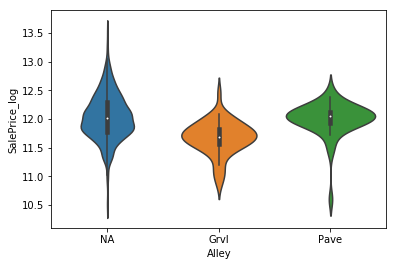

In [56]:
data['Alley'] = data['Alley'].fillna('NA')
sns.violinplot(x='Alley', y='SalePrice_log', data=data)

In [57]:
cat_vars.append('Alley')

## Fence

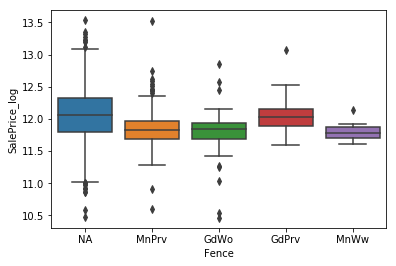

In [58]:
data['Fence'] = data['Fence'].fillna('NA')
sns.boxplot(x='Fence', y='SalePrice_log', data=data)

In [59]:
cat_vars.append('Fence')

In [60]:
data.loc[:, data.isna().any()].isna().sum()

LotFrontage       486
MSZoning            4
MiscFeature      2814
PoolQC           2909
SalePrice_log    1459
dtype: int64

## Pool Variables

In [61]:
both_idx = data.index[(data['PoolArea'] == 0) & (data['PoolQC'].isna())]
data.loc[both_idx, 'PoolQC'] = data.loc[both_idx, 'PoolQC'].fillna('NA')
data[data['PoolQC'].isna()]['OverallQual'] # below average, above average, fair

Id
2421    4
2504    6
2600    3
Name: OverallQual, dtype: int64

In [62]:
data.loc[2421, 'PoolQC'] = 'TA'
data.loc[2504, 'PoolQC'] = 'Gd'
data.loc[2600, 'PoolQC'] = 'Fa'

In [63]:
data['PoolQC'] = data['PoolQC'].map(qualities_map)

In [64]:
ord_vars.append('PoolQC')
num_vars.append('PoolArea')

## Lot Variables

In [65]:
neigh_meds = data.groupby('Neighborhood')['LotFrontage'].median()
data['LotFrontage'] = data.apply(
    lambda row: neigh_meds[row['Neighborhood']] if pd.isna(row['LotFrontage']) else row['LotFrontage'], axis=1)

In [66]:
num_vars.extend(['LotFrontage', 'LotArea'])

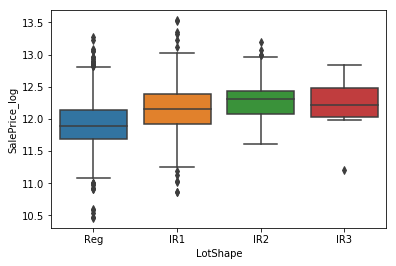

In [67]:
sns.boxplot(x='LotShape', y='SalePrice_log', data=data);

Expected this to be ordinal with Reg having the highest median saleprice. We'll leave these as categorical.

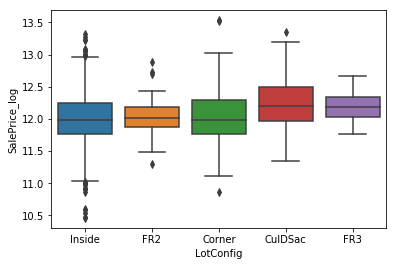

In [68]:
sns.boxplot(x='LotConfig', y='SalePrice_log', data=data);

In [69]:
cat_vars.extend(['LotShape', 'LotConfig'])

## MSZoning

In [70]:
data['MSZoning'].value_counts(dropna=False)

RL         2265
RM          460
FV          139
RH           26
C (all)      25
NaN           4
Name: MSZoning, dtype: int64

In [71]:
neigh_modes = data.groupby('Neighborhood')['MSZoning'].agg(lambda x: x.value_counts().index[0])
data['MSZoning'] = data.apply(
    lambda row: neigh_modes[row['Neighborhood']] if pd.isna(row['MSZoning']) else row['MSZoning'], axis=1)

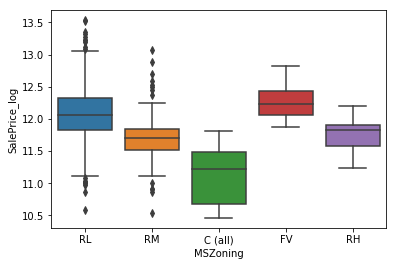

In [72]:
sns.boxplot(x='MSZoning', y='SalePrice_log', data=data);

In [73]:
cat_vars.append('MSZoning')

## Miscellaneous

In [74]:
data['MiscFeature'] = data['MiscFeature'].fillna('NA')

In [75]:
cat_vars.append('MiscFeature')
num_vars.append('MiscVal')

# Variable Groups Without Missing Values

In [76]:
print([var for var in data.select_dtypes(include=np.number).columns if var not in cat_vars+num_vars+ord_vars])

['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'EnclosedPorch', 'FullBath', 'GrLivArea', 'HalfBath', 'LowQualFinSF', 'MSSubClass', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'ScreenPorch', 'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'SalePrice_log']


In [77]:
num_vars.extend(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'EnclosedPorch', 
                 'FullBath', 'GrLivArea', 'HalfBath', 'LowQualFinSF', 
                 'OpenPorchSF', 'ScreenPorch', 
                 'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd'])

In [78]:
print([var for var in data.select_dtypes(include=np.number).columns if var not in cat_vars+num_vars+ord_vars])

['MSSubClass', 'MoSold', 'OverallCond', 'OverallQual', 'YrSold', 'SalePrice_log']


In [79]:
ord_vars.extend(['OverallCond', 'OverallQual'])

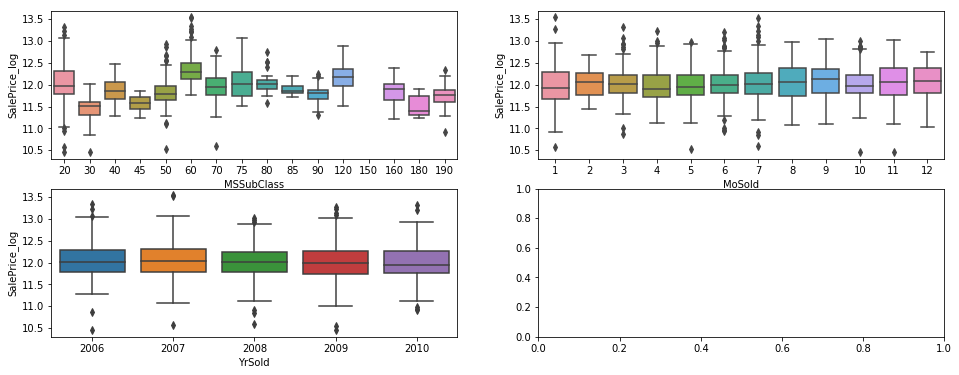

In [80]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,6))
sns.boxplot(x='MSSubClass', y='SalePrice_log', data=data, ax=ax[0,0]);
sns.boxplot(x='MoSold', y='SalePrice_log', data=data, ax=ax[0,1]);
sns.boxplot(x='YrSold', y='SalePrice_log', data=data, ax=ax[1,0]);

In [81]:
cat_vars.extend(['MSSubClass','MoSold', 'YrSold'])

# Converting Other Categories to Ordinal

In [82]:
print([var for var in data.select_dtypes(exclude=np.number).columns if var not in cat_vars+num_vars+ord_vars])

['BldgType', 'CentralAir', 'Condition1', 'Condition2', 'Foundation', 'Heating', 'HeatingQC', 'HouseStyle', 'LandContour', 'LandSlope', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'Street']


In [83]:
data['CentralAir'] = data['CentralAir'].map({'Y': True, 'N': False})
data['HeatingQC'] = data['HeatingQC'].map(qualities_map)
cat_vars.extend(['CentralAir', 'Street'])
ord_vars.append('HeatingQC')

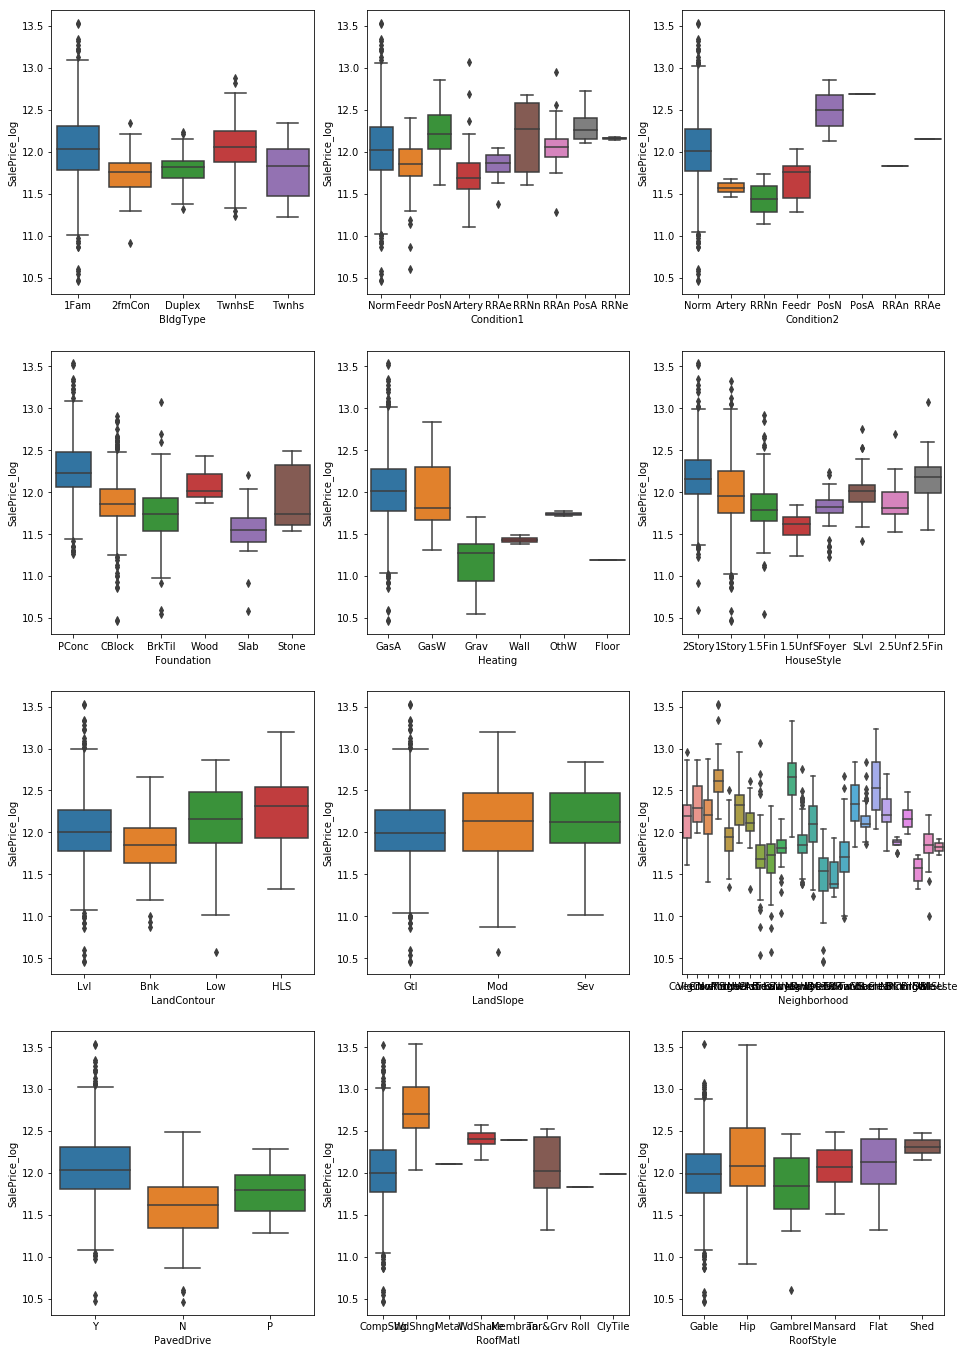

In [84]:
variables = [var for var in data.select_dtypes(exclude=np.number).columns 
             if var not in cat_vars+num_vars+ord_vars]
nrows = int(np.ceil(len(variables) / 3))
fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(16,24))
for i, var in enumerate(variables):
    row, col = divmod(i, 3)
    sns.boxplot(x=var, y='SalePrice_log', data=data, ax=ax[row, col])

In [85]:
data['LandSlope'] = data['LandSlope'].map({'Sev': 0, 'Mod': 1, 'Gtl': 2})
data['PavedDrive'] = data['PavedDrive'].map({'N': 0, 'P': 1, 'Y': 2})

In [86]:
cat_vars.extend(['BldgType', 'Condition1', 'Condition2', 'Foundation', 'Heating', 
                 'HouseStyle', 'LandContour', 'Neighborhood', 'RoofMatl', 'RoofStyle'])
ord_vars.extend(['LandSlope', 'PavedDrive'])

In [87]:
print([var for var in data.columns if var not in num_vars+cat_vars+ord_vars])

['SalePrice_log']


# Feature Engineering

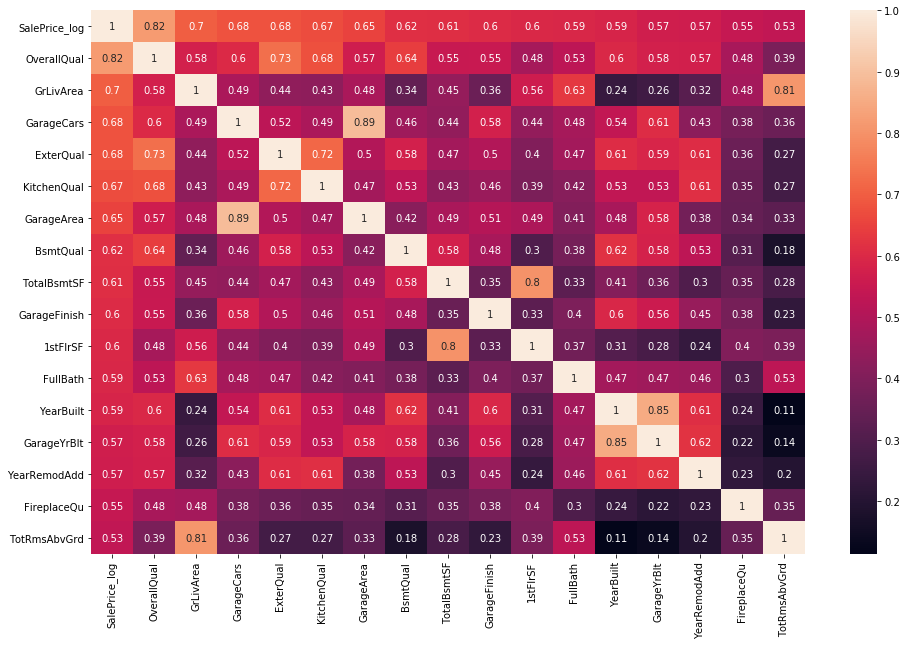

In [88]:
corr_price = abs(data.corr()['SalePrice_log']).sort_values(ascending=False) > 0.5
corr_price = corr_price[corr_price].index
plt.figure(figsize=(16,10))
sns.heatmap(data[corr_price].corr(), annot=True);

## Square Footage Variables

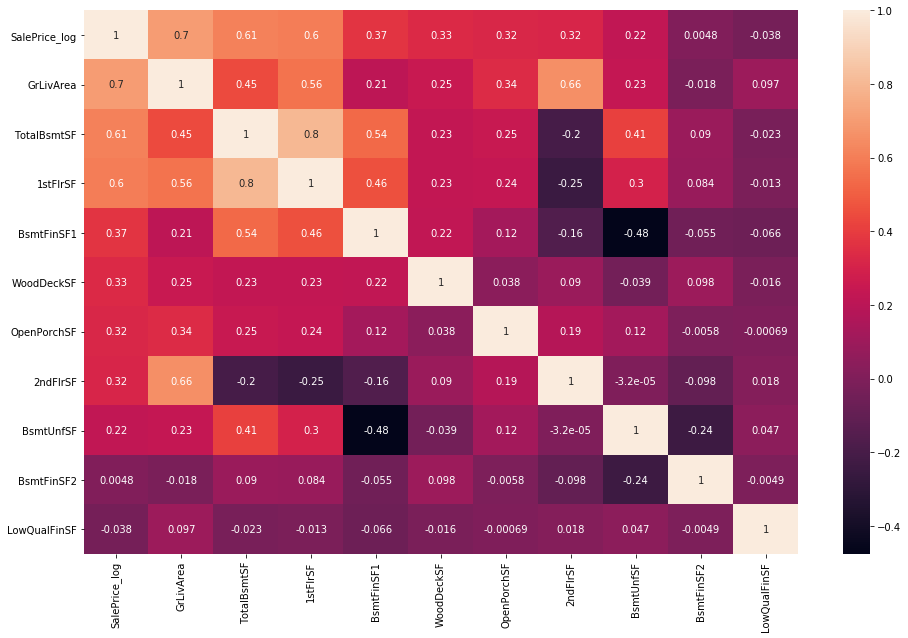

In [89]:
sf_vars = [var for var in data.columns if 'SF' in var] + ['GrLivArea', 'SalePrice_log']
sf_corr_order = data[sf_vars].corr()['SalePrice_log'].sort_values(ascending=False).index
plt.figure(figsize=(16,10))
sns.heatmap(data[sf_corr_order].corr(), annot=True);

In [90]:
indoor_sf = data[['TotalBsmtSF', 'GrLivArea']].sum(axis=1)
data['SalePrice_log'].corr(indoor_sf)

0.7732768410005625

In [91]:
to_drop = ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'GrLivArea']
data = data.drop(columns=to_drop)
num_vars = [var for var in num_vars if var not in to_drop]
data['TotSF'] = indoor_sf
num_vars.append('TotSF')

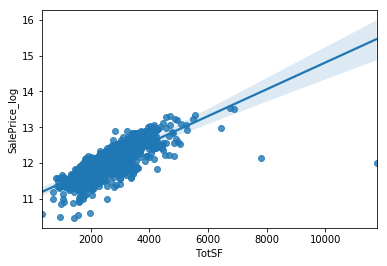

In [92]:
sns.regplot(x='TotSF', y='SalePrice_log', data=data);

In [93]:
print(data[(data.index.isin(train_ids)) & (data['TotSF'] >= 7750)][['TotSF', 'SalePrice_log']])

        TotSF  SalePrice_log
Id                          
524    7814.0      12.126759
1299  11752.0      11.982929


## Bathrooms

In [94]:
num_baths = data['BsmtFullBath'] + data['FullBath'] + data['BsmtHalfBath']/2 + data['HalfBath']/2
data['SalePrice_log'].corr(num_baths)

0.6730105940434346

In [95]:
data = data.drop(columns=['BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath'])
num_vars = [var for var in num_vars if var not in 
            ['BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath']]
data['Bath'] = num_baths
num_vars.append('Bath')

## Neighborhood

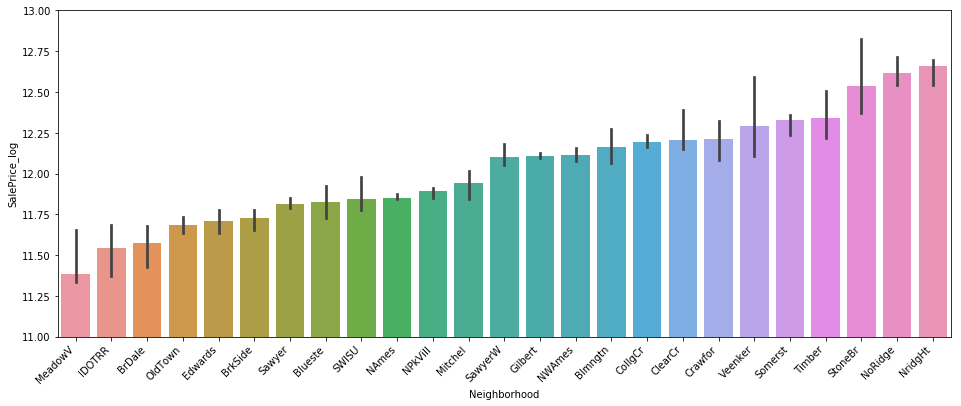

In [96]:
neigh_order = data.groupby('Neighborhood')['SalePrice_log'].median().sort_values().index
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x='Neighborhood', y='SalePrice_log', data=data, order=neigh_order, estimator=np.median, ax=ax);
plt.ylim(11,13);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [97]:
rich = ['StoneBr', 'NoRidge', 'NridgHt']
poor = ['MeadowV', 'IDOTRR', 'BrDale']
def get_wealth(neigh):
    if neigh in rich:
        return 2
    if neigh in poor:
        return 0
    return 1
data['NeighWealth'] = data['Neighborhood'].apply(get_wealth)
ord_vars.append('NeighWealth')

## Porch

In [98]:
enc_porch_vars = ['EnclosedPorch', '3SsnPorch', 'ScreenPorch']
data['EncPorch'] = data[enc_porch_vars].sum(axis=1)
data = data.drop(columns=enc_porch_vars)

op_porch_vars = ['WoodDeckSF', 'OpenPorchSF']
data['OpPorch'] = data[op_porch_vars].sum(axis=1)
data = data.drop(columns=op_porch_vars)

num_vars = [var for var in num_vars if var not in enc_porch_vars + op_porch_vars] + ['OpPorch', 'EncPorch']

## Age

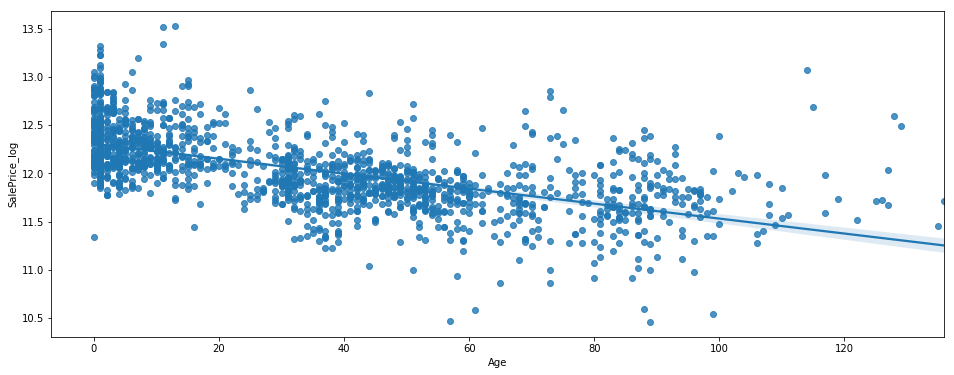

In [99]:
data['IsRemodeled'] = data['YearBuilt'] == data['YearRemodAdd']
data['IsNew'] = data['YearBuilt'] == data['YrSold']
data['Age'] = data['YrSold'] - data['YearBuilt']
plt.figure(figsize=(16,6))
sns.regplot(data['Age'], data['SalePrice_log']);

Make separate is_new flag variable since we can expect a disontinuity in the above linear relationship between 'lived-in' houses and entirely new houses.

In [100]:
to_drop = ['YearRemodAdd', 'YrSold', 'YearBuilt']
data = data.drop(columns=to_drop)
num_vars = [var for var in num_vars if var not in to_drop] + ['Age']
cat_vars.remove('YrSold')
cat_vars.extend(['IsRemodeled', 'IsNew'])

In [101]:
all_vars = num_vars + ord_vars + cat_vars
df_vars = data.columns.values
print(set(df_vars) - set(all_vars))

{'SalePrice_log'}


## Re-Binning Categorical Values with Fewer Than 10 Counts

In [102]:
for var in cat_vars:
    if (data[var].value_counts() < 10).any():
        print(data[var].value_counts())
        print()

VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64

VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

WD       2526
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

NA      2814
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150 

In [103]:
def bin_to_other(s, other, thresh=10):
    low_counts = s.value_counts() < thresh
    variables = low_counts.index[low_counts].values
    return s.apply(lambda val: other if val in variables else val)

In [104]:
data['Exterior1st'] = bin_to_other(data['Exterior1st'], 'Other')
data['Exterior2nd'] = bin_to_other(data['Exterior2nd'], 'Other')
data['SaleType'] = bin_to_other(data['SaleType'], 'Oth')
data['MSSubClass'] = bin_to_other(data['MSSubClass'], 'Other')
data['Condition1'] = bin_to_other(data['Condition1'], 'Other')
data['Condition2'] = bin_to_other(data['Condition2'], 'Other')
data['Heating'] = bin_to_other(data['Heating'], 'Other')
data['RoofMatl'] = bin_to_other(data['RoofMatl'], 'Other')

In [105]:
data['HasShed'] = data['MiscFeature'] == 'Shed'
cat_vars.append('HasShed')
data = data.drop(columns=['MiscFeature'])
cat_vars.remove('MiscFeature')

# Feature Selection

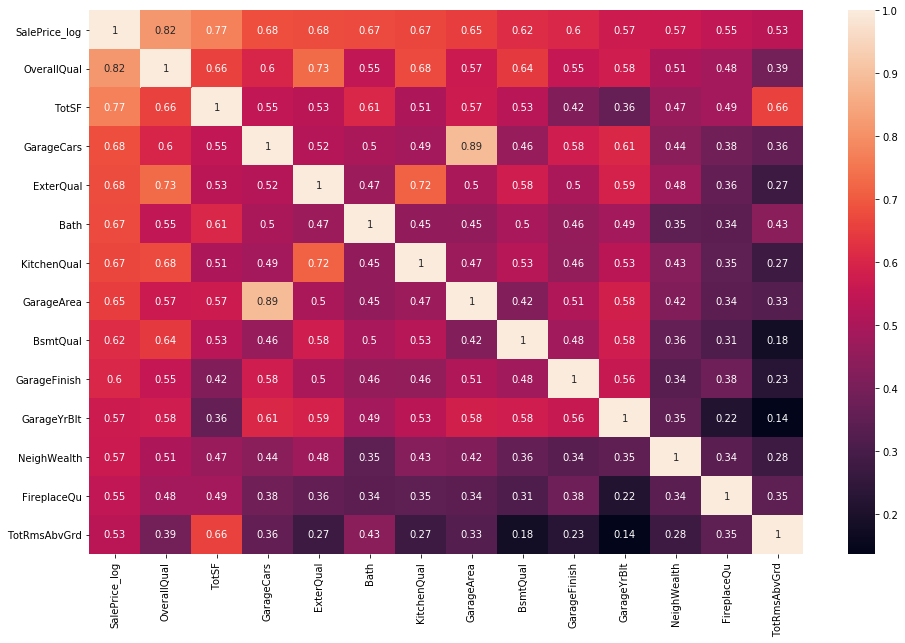

In [106]:
high_corr = data.corr()['SalePrice_log'].sort_values(ascending=False) > 0.5
var_high_corr = high_corr.index[high_corr]
plt.figure(figsize=(16, 10))
sns.heatmap(data[var_high_corr].corr(), annot=True);

In [107]:
data = data.drop(columns=['GarageArea'])
num_vars.remove('GarageArea')

# Transforming Data
Skewness

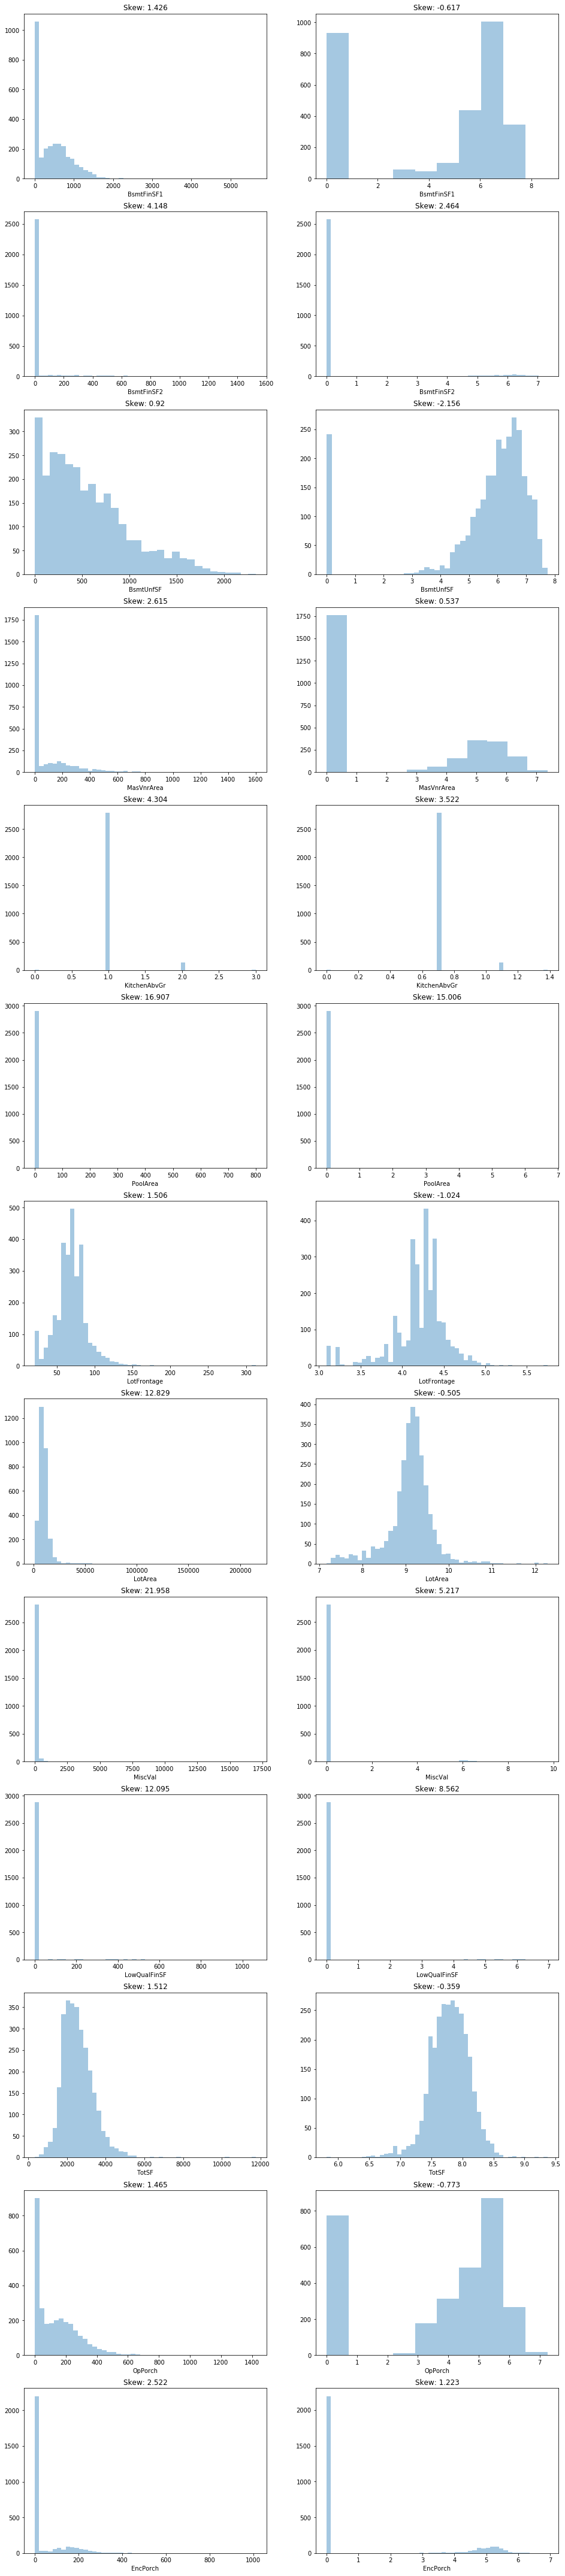

In [108]:
to_plot = []
for var in num_vars:
    if abs(data[var].skew()) > 0.8:
        to_plot.append(var)
fig, ax = plt.subplots(nrows=len(to_plot), ncols=2, figsize=(16,6*len(to_plot)))
for row, var in enumerate(to_plot):
    skew = data[var].skew()
    log_skew = np.log1p(data[var]).skew()
    sns.distplot(data[var], kde=False, ax=ax[row,0]).set_title('Skew: {}'.format(round(skew,3)))
    sns.distplot(np.log1p(data[var]), kde=False, ax=ax[row,1]).set_title('Skew: {}'.format(round(log_skew,3)))

In [109]:
to_log = ['BsmtFinSF1', 'BsmtUnfSF', 'MasVnrArea', 'LotFrontage', 'LotArea', 'TotSF', 'OpPorch']
for var in to_log:
    new_var = var+'_log'
    data[new_var] = np.log1p(data[var])
    data = data.drop(columns=[var])
    num_vars.remove(var)
    num_vars.append(new_var)

# Preparing Data for Modeling

In [110]:
data.to_csv('processed_not_scaled_no_dummies.csv')

## One-Hot Encode

In [111]:
data.shape

(2919, 70)

In [112]:
dummy_data = pd.get_dummies(data[cat_vars], drop_first=True)

In [113]:
dummy_data.columns[dummy_data.loc[test_ids].astype(bool).sum(axis=0) == 0]

Index(['HouseStyle_2.5Fin'], dtype='object')

In [114]:
dummy_data = dummy_data.drop(columns=['HouseStyle_2.5Fin'])

In [115]:
dummy_data.columns[dummy_data.loc[train_ids].astype(bool).sum(axis=0) < 10]

Index(['GarageType_CarPort', 'Exterior1st_Other', 'Exterior2nd_Brk Cmn',
       'SaleType_CWD', 'SaleType_ConLD', 'SaleCondition_AdjLand',
       'LotConfig_FR3', 'MSSubClass_Other', 'Condition1_Other',
       'Condition1_PosA', 'Condition2_Other', 'Foundation_Stone',
       'Foundation_Wood', 'Neighborhood_Blueste', 'Neighborhood_NPkVill',
       'RoofStyle_Mansard', 'RoofStyle_Shed'],
      dtype='object')

In [116]:
dummy_data = dummy_data.drop(columns=dummy_data.columns[dummy_data.loc[train_ids].astype(bool).sum(axis=0) < 10])

In [117]:
data = data.drop(columns=cat_vars).merge(dummy_data, left_index=True, right_index=True)
data.shape

(2919, 161)

In [118]:
data.to_csv('processed_has_dummies_not_scaled.csv')

## Split

In [119]:
train = data.loc[train_ids]
test = data.loc[test_ids].drop(columns=['SalePrice_log'])
print(train.shape)
print(test.shape)

(1460, 161)
(1459, 160)


## Remove Outliers from Training Set

In [120]:
train = train.drop(index=[524, 1299])

## Scaling

In [121]:
scaler = RobustScaler()
train[num_vars+ord_vars] = scaler.fit_transform(train[num_vars+ord_vars])
test[num_vars+ord_vars] = scaler.transform(test[num_vars+ord_vars])
X = train.drop(columns=['SalePrice_log'])
y = train['SalePrice_log']

# Modeling (Finally)

In [122]:
lasso_cv = LassoCV().fit(X, y)
alpha_lasso = lasso_cv.alpha_

In [123]:
rmse_list = []
for state in range(10):
    lasso = Lasso(alpha_lasso)
    k_fold = KFold(shuffle=True, random_state=state)
    rmse_list.append(np.sqrt(-1*cross_val_score(lasso, X, y, cv=k_fold, scoring='neg_mean_squared_error')).mean())
rmse_list = np.array(rmse_list)
print(rmse_list.mean(), rmse_list.std())

0.124365745910365 0.0003742902436452035


In [124]:
ridge_cv = RidgeCV().fit(X, y)
alpha_ridge = ridge_cv.alpha_

In [125]:
rmse_list = []
for state in range(10):
    ridge = Ridge(alpha_ridge)
    k_fold = KFold(shuffle=True, random_state=state)
    rmse_list.append(np.sqrt(-1*cross_val_score(ridge, X, y, cv=k_fold, scoring='neg_mean_squared_error')).mean())
rmse_list = np.array(rmse_list)
print(rmse_list.mean(), rmse_list.std())

0.11460873169360349 0.0008077827278155069


In [126]:
elnet_cv = ElasticNetCV().fit(X, y)
alpha_elnet = elnet_cv.alpha_

In [127]:
rmse_list = []
for state in range(10):
    elnet = ElasticNet(alpha_elnet)
    k_fold = KFold(shuffle=True, random_state=state)
    rmse_list.append(np.sqrt(-1*cross_val_score(elnet, X, y, cv=k_fold, scoring='neg_mean_squared_error')).mean())
rmse_list = np.array(rmse_list)
print(rmse_list.mean(), rmse_list.std())

0.12450059706407872 0.00038485969925033915


In [128]:
X = train.drop(columns=['SalePrice_log'])
y = train['SalePrice_log']

In [129]:
xgb = XGBRegressor(objective='reg:squarederror')
k_fold = KFold(shuffle=True, random_state=0)
print(np.sqrt(-1*cross_val_score(xgb, X, y, cv=k_fold, scoring='neg_mean_squared_error')).mean())

0.12379718871665957


In [130]:
rmse_list = []
for state in range(10):
    xgb = XGBRegressor(objective='reg:squarederror')
    k_fold = KFold(shuffle=True, random_state=state)
    rmse_list.append(np.sqrt(-1*cross_val_score(xgb, X, y, cv=k_fold, scoring='neg_mean_squared_error')).mean())
rmse_list = np.array(rmse_list)
print(rmse_list.mean(), rmse_list.std())

0.1235127143456721 0.0012715831887605922


Ridge regression with parameter alpha_ridge has the best rmse, averaged over 30 splits of 5-fold cross validation. 

In [131]:
ridge = Ridge(alpha_ridge).fit(X, y)
train_pred = ridge.predict(X)
test_pred = ridge.predict(test)

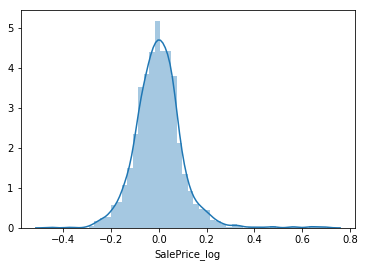

In [132]:
sns.distplot(train_pred - y);

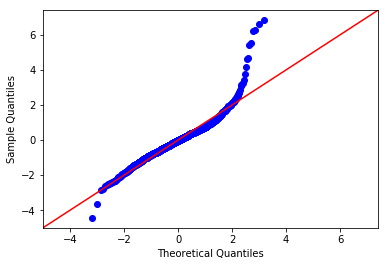

In [133]:
sm.qqplot(train_pred - y, fit=True, line='45');

In [134]:
real_scale = np.exp(test_pred) - 1
report = pd.DataFrame({'Id': test.index, 'SalePrice': real_scale})

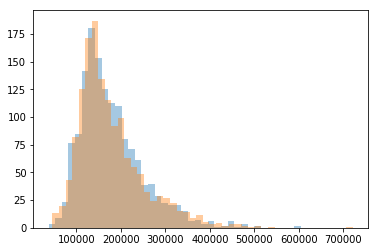

In [135]:
sns.distplot(np.exp(train_pred)+1, kde=False);
sns.distplot(np.exp(test_pred)+1, kde=False);

In [136]:
report.to_csv('submission.csv', index=False)